In [61]:
import pandas as pd
import numpy as np
import json
import re
import string
from nltk.corpus import stopwords
import nltk
import xgboost as xgb
import matplotlib.pylab as plt
import seaborn as sns
import pickle
import sklearn.feature_selection
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
with open('.\oos-eval-master\data\data_full.json') as data_file:
    data = json.load(data_file)

In [63]:
def format_data(filename):
    return pd.DataFrame(data=filename, columns=["text", "intent"])

In [64]:
train = format_data(data['train'])
val = format_data(data['val'])
test = format_data(data['test'])
oos_train = format_data(data['oos_train'])
oos_val = format_data(data['oos_val'])
oos_test = format_data(data['oos_test'])

In [65]:
train.to_csv('train.csv')
val.to_csv('val.csv')
test.to_csv('test.csv')

In [66]:
files = [(train,'train'),(val,'val'),(test,'test'),(oos_train,'oos_train'),(oos_val,'oos_val'),(oos_test,'oos_test')]

for file,name in files:
    file.columns = ['text','intent']
    print(f'{name} shape:{file.shape}, {name} has {train.isna().sum().sum()} null values')

train shape:(15000, 2), train has 0 null values
val shape:(3000, 2), val has 0 null values
test shape:(4500, 2), test has 0 null values
oos_train shape:(100, 2), oos_train has 0 null values
oos_val shape:(100, 2), oos_val has 0 null values
oos_test shape:(1000, 2), oos_test has 0 null values


In [67]:
random_class = train.intent.sample(n=20,random_state=3)

In [68]:
classes = random_class.to_list()

In [69]:
train_20 = train.loc[train['intent'].isin(classes)]
val_20 = val.loc[val['intent'].isin(classes)]
test_20 = test.loc[test['intent'].isin(classes)]

In [70]:
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    wn = nltk.WordNetLemmatizer()
    text = re.sub('[0-9]+', '', text)
    text = re.sub('#', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stop_words]
    text = [wn.lemmatize(word) for word in text]
    
    return text

In [71]:
train_20['text'] = train_20['text'].apply(lambda x: clean_text(x))

C:\Users\soura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
val_20['text'] = val_20['text'].apply(lambda x: clean_text(x))
test_20['text'] = test_20['text'].apply(lambda x: clean_text(x))

C:\Users\soura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\soura\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_vect_fit = tfidf_vect.fit(train_20['text'].apply(lambda x: ' '.join(x)))
tfidf_train = tfidf_vect_fit.transform(train_20['text'].apply(lambda x: ' '.join(x)))
tfidf_val = tfidf_vect_fit.transform(val_20['text'].apply(lambda x: ' '.join(x)))
tfidf_test = tfidf_vect_fit.transform(test_20['text'].apply(lambda x: ' '.join(x)))

In [74]:
tfidf_train

<2000x4240 sparse matrix of type '<class 'numpy.float64'>'
	with 13676 stored elements in Compressed Sparse Row format>

In [17]:
dic_vacab = tfidf_vect.vocabulary_

In [19]:

y = train_20["intent"]
X_names = tfidf_vect.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = sklearn.feature_selection.chi2(tfidf_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [56]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    #print("  . Score:",dtf_features["score"])
    print(" ")


# account_blocked:
  . selected features: 255
  . top features: account,account blocked,account frozen,bank,bank account,blocked,frozen,hold,reason,block
 
# book_hotel:
  . selected features: 490
  . top features: book,hotel,hotel room,monday,people,room,th,review,march,book hotel
 
# cancel:
  . selected features: 163
  . top features: cancel,stop,talking,quit,stop talking,abort,process,please cancel,shut,quiet
 
# definition:
  . selected features: 207
  . top features: definition,mean,meaning,word,define,ataraxy,flange,zesty,affiliate,altruism
 
# find_phone:
  . selected features: 132
  . top features: cellphone,find,find phone,help find,locate,locate phone,lost phone,phone,help,find cellphone
 
# gas_type:
  . selected features: 145
  . top features: car,car need,car take,fill,fuel,fuel car,gas,gas car,gas need,kind
 
# income:
  . selected features: 183
  . top features: income,much make,salary,tell income,make,earn,pay,job,information income,tell salary
 
# interest_rate:
  . s

In [21]:
tfidf_vect = TfidfVectorizer(vocabulary=X_names)
tfidf_vect_fit = tfidf_vect.fit(train_20['text'].apply(lambda x: ' '.join(x)))
tfidf_train = tfidf_vect_fit.transform(train_20['text'].apply(lambda x: ' '.join(x)))
tfidf_val = tfidf_vect_fit.transform(val_20['text'].apply(lambda x: ' '.join(x)))
tfidf_test = tfidf_vect_fit.transform(test_20['text'].apply(lambda x: ' '.join(x)))

In [23]:
le = preprocessing.LabelEncoder()
l = le.fit(train_20.intent.to_list())
y_train = l.transform(train_20.intent.to_list())
y_val = l.transform(val_20.intent.to_list())
y_test = l.transform(test_20.intent.to_list())

In [24]:
x_train = pd.DataFrame(tfidf_train.toarray())
x_val = pd.DataFrame(tfidf_val.toarray())
x_test = pd.DataFrame(tfidf_test.toarray())

In [25]:
xgb_classifier = xgb.XGBClassifier()
xgb_clf = xgb_classifier.fit(x_train,y_train)

C:\Users\soura\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:09:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
predict = xgb_clf.predict(x_test)
predict_proba = xgb_clf.predict_proba(x_test)

In [27]:
## Accuracy, Precision, Recall
accuracy = sklearn.metrics.accuracy_score(y_test, predict)
auc = sklearn.metrics.roc_auc_score(y_test, predict_proba, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print(classification_report(y_test, predict))

Accuracy: 0.93
Auc: 1.0
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00        30
           2       0.62      0.97      0.75        30
           3       0.93      0.93      0.93        30
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00        30
           6       0.81      0.83      0.82        30
           7       1.00      0.97      0.98        30
           8       0.92      0.77      0.84        30
           9       0.97      1.00      0.98        30
          10       0.97      0.93      0.95        30
          11       0.91      0.97      0.94        30
          12       1.00      0.80      0.89        30
          13       1.00      0.93      0.97        30
          14       1.00      0.93      0.97        30
          15       0.97      1.00      0.98        30
          16       0.96      0.73      0.83        30
   

In [28]:
cm = confusion_matrix(y_test, predict)

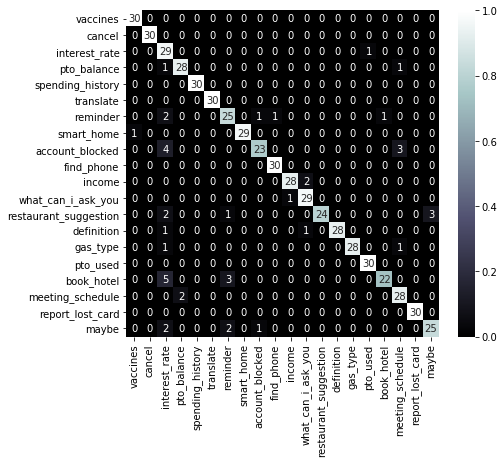

In [47]:
## Plot confusion matrix
classes = set(train_20.intent.to_list())
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

plot_confusion_matrix(cm, classes)

In [30]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values

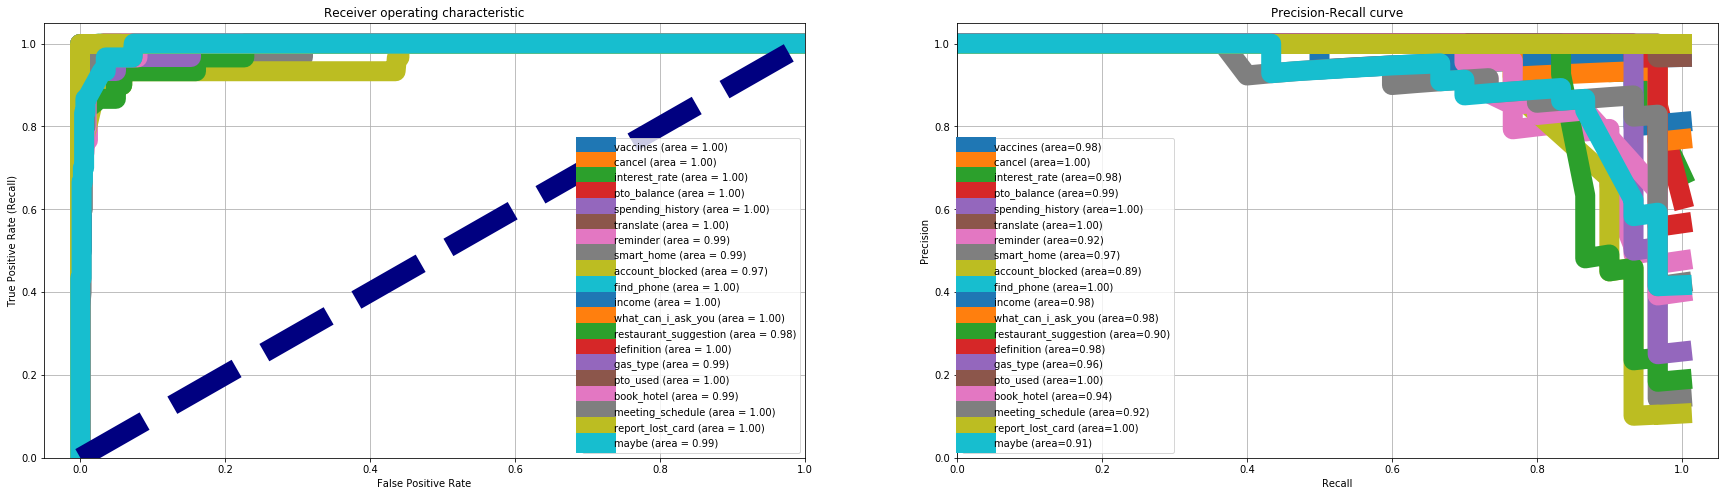

In [54]:
classes = list(classes)
## Plot roc
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(30,8))

for i in range(len(classes)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test_array[:,i],  
                           predict_proba[:,i])
    ax[0].plot(fpr, tpr, lw=20, 
              label='{0} (area = {1:0.2f})'
             ''.format(classes[i], 
                              sklearn.metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=20, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
                 y_test_array[:,i], predict_proba[:,i])
    ax[1].plot(recall, precision, lw=20, 
               label='{0} (area={1:0.2f})'''.format(classes[i], 
                                  sklearn.metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [ ]:
pickle.dump(xgb_clf, open("xgbmodel.pkl", "wb"))